##**Importing Libraries**

In [1]:
import os
import cv2
import joblib
import random

import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

from sklearn.svm import LinearSVC
from scipy.cluster.vq import kmeans,vq
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix,accuracy_score,ConfusionMatrixDisplay

##**Objects Dataset**

**Downloading Dataset From Google Drive**

In [ ]:
!pip install --upgrade --no-cache-dir gdown #installing gdown
!gdown https://drive.google.com/uc?id=1Afj_TLyeyB29HbyaoriNT87TD56UYzWV #downloading objects dataset from google drive
!unzip -q objects_dataset.zip #unzipping the dataset file

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Attempting uninstall: gdown
    Found existing installation: gdown 4.4.0
    Uninstalling gdown-4.4.0:
      Successfully uninstalled gdown-4.4.0
Downloading...
From: https://drive.google.com/uc?id=1Afj_TLyeyB29HbyaoriNT87TD56UYzWV
To: /content/objects_dataset.zip
100% 891k/891k [00:00<00:00, 77.2MB/s]


**Specifying Training Path**

In [ ]:
#extracting class names from directories
train_path="./objects_dataset/train/"
class_names_train=os.listdir(train_path)

print(class_names_train)

['accordion', 'dollar_bill', 'motorbike', 'Soccer_Ball']


**Assembling Training Image Paths**

In [ ]:
image_paths_train=[]
image_classes_train=[]

#function for extracting images from a given directory 
def img_list(path):
    return (os.path.join(path,f) for f in os.listdir(path))

#appending image paths for training set
for training_name in class_names_train:
    dir_=os.path.join(train_path,training_name)
    class_path_train=img_list(dir_)
    image_paths_train+=class_path_train

len(image_paths_train)

56

**Corresponding Class Labels & Images (Training)**

In [ ]:
#specifying class labels for training set
image_classes_train_0=[0]*14
image_classes_train_1=[1]*14
image_classes_train_2=[2]*14
image_classes_train_3=[3]*14

image_classes_train = image_classes_train_0 + image_classes_train_1 + image_classes_train_2 + image_classes_train_3

D_train=[]

#combining image paths and class labels
for i in range(len(image_paths_train)):
    D_train.append((image_paths_train[i],image_classes_train[i]))

#shuffling the train set
dataset_train = D_train
random.shuffle(dataset_train)

image_paths, y_train = zip(*dataset_train)

**Specifying Testing Path**

In [ ]:
#extracting class names from directories
test_path="./objects_dataset/test/"
class_names_test=os.listdir(test_path)

print(class_names_test)

['accordion', 'dollar_bill', 'motorbike', 'Soccer_Ball']


**Assembling Testing Image Paths**

In [ ]:
image_paths_test=[]
image_classes_test=[]

#function for extracting images from a given directory 
def img_list(path):
    return (os.path.join(path,f) for f in os.listdir(path))

#appending image paths for test set
for testing_name in class_names_test:
    dir_=os.path.join(test_path,testing_name)
    class_path_test=img_list(dir_)
    image_paths_test+=class_path_test

len(image_paths_test)

8

**Corresponding Class Labels & Images (Testing)**

In [ ]:
#specifying class labels for test set
image_classes_test_0=[0]*2
image_classes_test_1=[1]*2
image_classes_test_2=[2]*2
image_classes_test_3=[3]*2

image_classes_test = image_classes_test_0 + image_classes_test_1 + image_classes_test_2 + image_classes_test_3

D_test=[]

#combining image paths and class labels
for i in range(len(image_paths_test)):
    D_test.append((image_paths_test[i],image_classes_test[i]))

#shuffling the test set
dataset_test = D_test
random.shuffle(dataset_test)
image_paths_test, y_test = zip(*dataset_test)

**Initializing Descriptors**

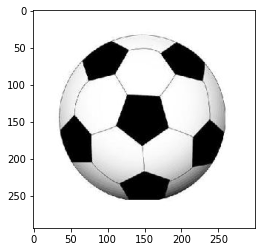

In [ ]:
des_list=[] #making a list for descriptors

sift=cv2.SIFT_create() #initializing sift

im=cv2.imread(image_paths[1]) #reading a sample image

im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) #converting the sample image to grayscale

plt.imshow(im, cmap="gray", vmin=0, vmax=255) #showing the sample image

**Trying ORB Features**

In [ ]:
des_list_orb=[] #making a list of descriptors for orb features

orb=cv2.ORB_create() #initializing orb

#appending orb descriptors for the training set
for image_pat in image_paths:
    im=cv2.imread(image_pat)
    im=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    keypoints,descriptor=orb.detectAndCompute(im,None)
    des_list_orb.append((image_pat,descriptor))

**Drawing Keypoints**

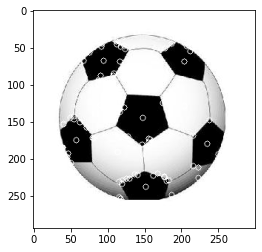

In [ ]:
#function for drawing keypoints on the grayscale image
def draw_keypoints(vis, keypoints, color = (255, 0, 0)):
    for kp in keypoints:
            x, y = kp.pt
            plt.imshow(cv2.circle(vis, (int(x), int(y)), 4, color), cmap="gray", vmin=0, vmax=255)

#drawing sift keypoints
kp = sift.detect(im,None)
kp, des = sift.compute(im, kp)
img=draw_keypoints(im,kp)

**Detecting & Computing SIFT Features**

In [ ]:
#appending descriptors for the training set
for image_pat in image_paths:
    im=cv2.imread(image_pat)
    im=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    keypoints,descriptor=sift.detectAndCompute(im,None)
    des_list.append((image_pat,descriptor))

**Stacking Extracted Descriptors**

In [ ]:
#stacking sift descriptors
descriptors=des_list[0][1]
for image_path,descriptor in des_list[1:]:
    descriptors=np.vstack((descriptors,descriptor))

descriptors.shape

(25089, 128)

**Clustering Extracted Features With KMeans**

In [ ]:
#converting descriptor type to float
descriptors_float=descriptors.astype(float)

#KMeans clustering
k=200
voc,variance=kmeans(descriptors_float,k,1)

**Creating Image Histograms**

In [ ]:
im_features=np.zeros((len(image_paths),k),"float32")

#counting the number of extracted features in each image 
for i in range(len(image_paths)):
    words,distance=vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w]+=1

**Scaling Image Histograms**

In [ ]:
#scaling image features with standard scaler
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

**Fitting SVM Classifier**

In [ ]:
clf=LinearSVC(max_iter=80000) #initializing svm classifier
clf.fit(im_features,np.array(y_train)) #training svm

LinearSVC(max_iter=80000)

**Fitting Random Forest Classifier**

In [ ]:
clf2=RandomForestClassifier() #initializing random forest classifier
clf2.fit(im_features,np.array(y_train)) #training random forest

RandomForestClassifier()

**Computing SIFT Features For Test Images**

In [ ]:
des_list_test=[]

#appending descriptors for the test set
for image_pat in image_paths_test:
    image=cv2.imread(image_pat)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints_test,descriptor_test=sift.detectAndCompute(image,None)
    des_list_test.append((image_pat,descriptor_test))

len(image_paths_test)

./objects_dataset/test/motorbike/image_0044.jpg
./objects_dataset/test/dollar_bill/image_0048.jpg
./objects_dataset/test/accordion/image_0026.jpg
./objects_dataset/test/Soccer_Ball/image_0032.jpg
./objects_dataset/test/motorbike/image_0030.jpg
./objects_dataset/test/Soccer_Ball/image_0046.jpg
./objects_dataset/test/dollar_bill/image_0040.jpg
./objects_dataset/test/accordion/image_0023.jpg


8

**Creating Histograms For Test Images**

In [ ]:
test_features=np.zeros((len(image_paths_test),k),"float32")

#counting the number of extracted features in each test image 
for i in range(len(image_paths_test)):
    words,distance=vq(des_list_test[i][1],voc)
    for w in words:
        test_features[i][w]+=1

In [ ]:
test_features

array([[ 0.,  1.,  1., ...,  1.,  1.,  0.],
       [ 3.,  0.,  0., ...,  1.,  0.,  0.],
       [ 5.,  1.,  7., ...,  2.,  1.,  3.],
       ...,
       [ 0.,  0.,  0., ...,  1.,  1.,  1.],
       [10.,  3.,  2., ...,  2.,  2., 11.],
       [ 1.,  2.,  2., ...,  1.,  2.,  0.]], dtype=float32)

In [ ]:
test_features=stdslr.transform(test_features)

**Listing Down Actual & Predicted Class Labels (SVM)**

In [ ]:
true_classes=[]

#listing actual class labels 
for i in y_test:
    if i==0:
        true_classes.append("accordion")
    elif i==1:
        true_classes.append("dollar_bill")
    elif i==2:
        true_classes.append("motorbike")
    else:
        true_classes.append("Soccer_Ball")

predict_classes=[]

#listing predicted class labels from SVM
for i in clf.predict(test_features):
    if i==0:
        predict_classes.append("accordion")
    elif i==1:
        predict_classes.append("dollar_bill")
    elif i==2:
        predict_classes.append("motorbike")
    else:
        predict_classes.append("Soccer_Ball")

print(true_classes)
print(predict_classes)

['motorbike', 'dollar_bill', 'accordion', 'Soccer_Ball', 'motorbike', 'Soccer_Ball', 'dollar_bill', 'accordion']
['motorbike', 'dollar_bill', 'accordion', 'Soccer_Ball', 'Soccer_Ball', 'Soccer_Ball', 'dollar_bill', 'accordion']


**Listing Down Actual & Predicted Class Labels (Random Forest)**

In [ ]:
predict_classes2=[]

#listing predicted class labels from random forest
for i in clf2.predict(test_features):
    if i==0:
        predict_classes2.append("accordion")
    elif i==1:
        predict_classes2.append("dollar_bill")
    elif i==2:
        predict_classes2.append("motorbike")
    else:
        predict_classes2.append("Soccer_Ball")

print(true_classes)
print(predict_classes2)

['motorbike', 'dollar_bill', 'accordion', 'Soccer_Ball', 'motorbike', 'Soccer_Ball', 'dollar_bill', 'accordion']
['motorbike', 'dollar_bill', 'accordion', 'Soccer_Ball', 'motorbike', 'Soccer_Ball', 'dollar_bill', 'accordion']


**Classification Accuracies (SVM & Random Forest)**

In [ ]:
accuracy=accuracy_score(true_classes,predict_classes) #accuracy score for svm
accuracy2=accuracy_score(true_classes,predict_classes2) #accuracy score for random forest

print("SVM Accuracy: ", accuracy)
print("Random Forest Accuracy: ", accuracy2)

SVM Accuracy:  0.875
Random Forest Accuracy:  1.0


**Quantitative Results (Class Accuracy, F1 Score, TP Rate, FP Rate)**

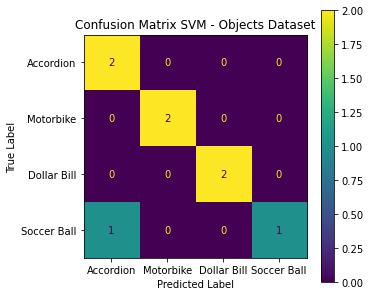


SVM Classifier
Classes: Accordion, Motorbike, Dollar Bill, Soccer Ball
True Positive Rate:  [1.  1.  1.  0.5]
False Positive Rate:  [0.17 0.   0.   0.  ]
F1 Score:  [0.8  1.   1.   0.67]
Accurcay:  [0.88 1.   1.   0.88]
Total Accurcay:  0.938



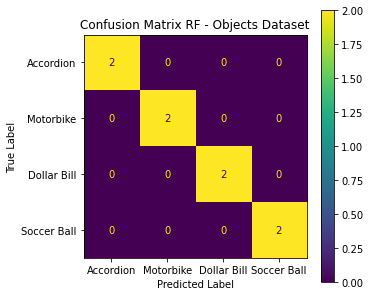


Random Forest classifier
Classes: Accordion, Motorbike, Dollar Bill, Soccer Ball
True Positive Rate:  [1. 1. 1. 1.]
False Positive Rate:  [0. 0. 0. 0.]
F1 Score:  [1. 1. 1. 1.]
Accurcay:  [1. 1. 1. 1.]
Total Accurcay:  1.0



In [ ]:
#developing a confusion matrix for svm
cm = confusion_matrix(true_classes,predict_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Accordion', 'Motorbike', 'Dollar Bill', 'Soccer Ball'])

fig, ax = plt.subplots(figsize=(5,5))
cm_display.plot(ax=ax)
plt.title("Confusion Matrix SVM - Objects Dataset")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

FP = cm.sum(axis=0) - np.diag(cm) #false positive
FN = cm.sum(axis=1) - np.diag(cm) #false negative
TP = np.diag(cm) #true positive
TN = cm.sum() - (FP + FN + TP) #true negative

TPR = TP/(TP+FN) #true positive rate
FPR = FP/(FP+TN) #false positive rate
F1 = TP/(TP + (0.5*(FP+FN))) #f1 score
ACC = (TP+TN)/(TP+FP+FN+TN) #model accuracy

print()
print("SVM Classifier")
print("Classes: Accordion, Motorbike, Dollar Bill, Soccer Ball")
print("True Positive Rate: ", np.round(TPR, 2))
print("False Positive Rate: ", np.round(FPR, 2))
print("F1 Score: ", np.round(F1, 2))
print("Accurcay: ", np.round(ACC, 2))
print("Total Accurcay: ", round(sum(ACC)/4, 3))
print()

#developing a confusion matrix for random forest
cm2 = confusion_matrix(true_classes,predict_classes2)
cm2_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ['Accordion', 'Motorbike', 'Dollar Bill', 'Soccer Ball'])

fig, ax = plt.subplots(figsize=(5,5))
cm2_display.plot(ax=ax)
plt.title("Confusion Matrix RF - Objects Dataset")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

FP = cm2.sum(axis=0) - np.diag(cm2) #false positive
FN = cm2.sum(axis=1) - np.diag(cm2) #false negative
TP = np.diag(cm2) #true positive
TN = cm2.sum() - (FP + FN + TP) #true negative

TPR = TP/(TP+FN) #true positive rate
FPR = FP/(FP+TN) #false positive rate
F1 = TP/(TP + (0.5*(FP+FN))) #f1 score
ACC = (TP+TN)/(TP+FP+FN+TN) #accuracy

print()
print("Random Forest classifier")
print("Classes: Accordion, Motorbike, Dollar Bill, Soccer Ball")
print("True Positive Rate: ", np.round(TPR, 2))
print("False Positive Rate: ", np.round(FPR, 2))
print("F1 Score: ", np.round(F1, 2))
print("Accurcay: ", np.round(ACC, 2))
print("Total Accurcay: ", round(sum(ACC)/4, 3))
print()

**Qualitative Results (Correctly & Incorrectly Classified Images)**

Correctly Classified Image
True Label:  Soccer_ball


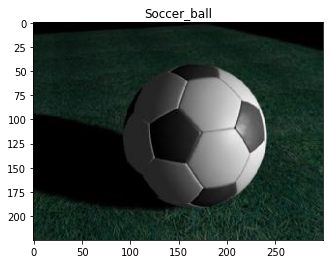

In [ ]:
#showing a correctly classified object
im=cv2.imread(image_paths_test[5])
plt.imshow(im)
plt.title(predict_classes[5].capitalize())

print("Correctly Classified Image")
print("True Label: ", true_classes[5].capitalize())

Incorrectly Classified Image
True Label:  Motorbike


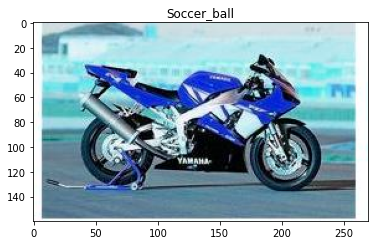

In [ ]:
#showing an incorrectly classified object
im=cv2.imread(image_paths_test[4])
plt.imshow(im)
plt.title(predict_classes[4].capitalize())

print("Incorrectly Classified Image")
print("True Label: ", true_classes[4].capitalize())

**Saving Trained Classifiers With JobLib**

In [ ]:
#saving the trained svm classifier
filename = "sift_objects_svm.joblib"
joblib.dump(clf, filename)

['sift_objects_svm.joblib']

In [ ]:
#saving the trained random forest classifier
filename = "sift_objects_rf.joblib"
joblib.dump(clf2, filename)

['sift_objects_rf.joblib']

##**Flower Dataset**

**Downloading Dataset From Google Drive**

In [ ]:
!pip install --upgrade --no-cache-dir gdown #installing gdown
!gdown https://drive.google.com/uc?id=1ZFHWEhJyztRliIAc9le4LaLLVJtQuDyE #downloading flowers dataset from google drive
!unzip -q flowers_dataset.zip #unzipping the dataset file

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Downloading...
From: https://drive.google.com/uc?id=1ZFHWEhJyztRliIAc9le4LaLLVJtQuDyE
To: /content/flowers_dataset.zip
100% 230M/230M [00:02<00:00, 97.8MB/s]


**Specifying Dataset Path**

In [ ]:
#extracting class names from directories
train_path="./flower_dataset/"
class_names=os.listdir(train_path)

print(class_names)

['daisy', 'sunflowers', 'dandelion', 'tulips', 'roses']


**Assembling Image Paths**

In [ ]:
image_paths=[]
image_classes=[]

#function for extracting images from a given directory
def img_list(path):
    return (os.path.join(path,f) for f in os.listdir(path))

#appending all image paths together
for training_name in class_names:
    dir_=os.path.join(train_path,training_name)
    class_path=img_list(dir_)
    image_paths+=class_path

len(image_paths)

3670

**Corresponding Labels & Splitting Dataset**

In [ ]:
#specifying class labels
image_classes_0=[0]*633
image_classes_1=[1]*699
image_classes_2=[2]*898
image_classes_3=[3]*799
image_classes_4=[4]*641

image_classes = image_classes_0 + image_classes_1 + image_classes_2 + image_classes_3 + image_classes_4

D=[]

#combining image paths and class labels
for i in range(len(image_paths)):
    D.append((image_paths[i],image_classes[i]))

#shuffling the dataset
dataset = D
random.shuffle(dataset)

#splitting the dataset into train and test sets
train = dataset[:2936]
test = dataset[2936:]

image_paths, y_train = zip(*train)
image_paths_test, y_test = zip(*test)

**Initializing Descriptors**

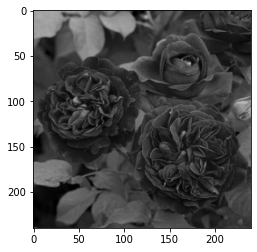

In [ ]:
des_list=[] #making a list of descriptors

sift=cv2.SIFT_create() #initializing sift

im=cv2.imread(image_paths[1]) #reading a sample image

im = cv2.cvtColor(im, cv2.COLOR_BGR2GRAY) #converting the sample image to grayscale

plt.imshow(im, cmap="gray", vmin=0, vmax=255) #showing the sample image

**Trying ORB Features**

In [ ]:
des_list_orb=[] #making a list of descriptors for orb features

orb=cv2.ORB_create() #initializing orb

#appending orb descriptors for the training set
for image_pat in image_paths:
    im=cv2.imread(image_pat)
    im=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    keypoints,descriptor=orb.detectAndCompute(im,None)
    des_list_orb.append((image_pat,descriptor))

**Drawing Keypoints**

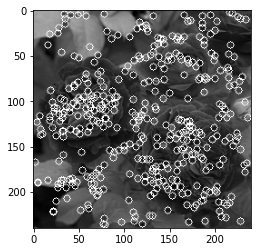

In [ ]:
#function for drawing keypoints on a grayscale image
def draw_keypoints(vis, keypoints, color = (255, 0, 0)):
    for kp in keypoints:
            x, y = kp.pt
            plt.imshow(cv2.circle(vis, (int(x), int(y)), 4, color), cmap="gray", vmin=0, vmax=255)

#drawing sift keypoints
kp = sift.detect(im,None)
kp, des = sift.compute(im, kp)
img=draw_keypoints(im,kp)

**Detecting & Computing SIFT Features**

In [ ]:
#appending descriptors for the training set
for image_pat in image_paths:
    im=cv2.imread(image_pat)
    im=cv2.cvtColor(im, cv2.COLOR_BGR2GRAY)
    keypoints,descriptor=sift.detectAndCompute(im,None)
    des_list.append((image_pat,descriptor))

**Stacking Extracted Features**

In [ ]:
#stacking sift descriptors
descriptors=des_list[0][1]
for image_path,descriptor in des_list[1:]:
    descriptors=np.vstack((descriptors,descriptor))

descriptors.shape

(1889432, 128)

**Clustering Extracted Features With KMeans**

In [ ]:
#converting descriptors type to float
descriptors_float=descriptors.astype(float)

#KMeans clustering
k=200
voc,variance=kmeans(descriptors_float,k,1)

**Creating Image Histograms**

In [ ]:
im_features=np.zeros((len(image_paths),k),"float32")

#counting the number of extracted features in each image
for i in range(len(image_paths)):
    words,distance=vq(des_list[i][1],voc)
    for w in words:
        im_features[i][w]+=1

**Scaliing Image Histograms**

In [ ]:
#scaling image features with standard scaler
stdslr=StandardScaler().fit(im_features)
im_features=stdslr.transform(im_features)

**Fitting SVM Classifier**

In [ ]:
clf=LinearSVC(max_iter=80000) #initializing svm classifier
clf.fit(im_features,np.array(y_train)) #training svm

LinearSVC(max_iter=80000)

**Fitting Random Forest Classifier**

In [ ]:
clf2=RandomForestClassifier() #initializing random forest classifier
clf2.fit(im_features,np.array(y_train)) #training random forest

RandomForestClassifier()

**Computing SIFT Features For Test Images**

In [ ]:
des_list_test=[]

#appending descriptors for the test set
for image_pat in image_paths_test:
    image=cv2.imread(image_pat)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    keypoints_test,descriptor_test=sift.detectAndCompute(image,None)
    des_list_test.append((image_pat,descriptor_test))

len(image_paths_test)

734

**Creating Histograms For Test Images**

In [ ]:
test_features=np.zeros((len(image_paths_test),k),"float32")

#counting the number of extracted features in each test image
for i in range(len(image_paths_test)):
    words,distance=vq(des_list_test[i][1],voc)
    for w in words:
        test_features[i][w]+=1

In [ ]:
test_features

array([[ 0.,  5.,  0., ...,  0.,  1.,  0.],
       [ 1.,  1.,  1., ...,  1.,  3.,  0.],
       [ 0.,  1.,  0., ...,  1.,  1.,  0.],
       ...,
       [ 0.,  4.,  4., ...,  7.,  4.,  7.],
       [ 1.,  1.,  0., ...,  2.,  0.,  0.],
       [ 3.,  9., 14., ..., 24.,  9.,  8.]], dtype=float32)

In [ ]:
test_features=stdslr.transform(test_features)

**Listing Down Actual & Predicted Class Labels (SVM)**

In [ ]:
true_classes=[]

#listing actual class labels
for i in y_test:
    if i==0:
        true_classes.append("daisy")
    elif i==1:
        true_classes.append("sunflowers")
    elif i==2:
        true_classes.append("dandelion")
    elif i==3:
        true_classes.append("tulips")
    else:
        true_classes.append("roses")

predict_classes=[]

#listing predicted class labels from svm
for i in clf.predict(test_features):
    if i==0:
        predict_classes.append("daisy")
    elif i==1:
        predict_classes.append("sunflowers")
    elif i==2:
        predict_classes.append("dandelion")
    elif i==3:
        predict_classes.append("tulips")
    else:
        predict_classes.append("roses")

print(true_classes)
print(predict_classes)

['roses', 'dandelion', 'sunflowers', 'dandelion', 'roses', 'daisy', 'roses', 'tulips', 'tulips', 'tulips', 'tulips', 'sunflowers', 'dandelion', 'roses', 'tulips', 'sunflowers', 'daisy', 'daisy', 'daisy', 'dandelion', 'tulips', 'daisy', 'sunflowers', 'daisy', 'tulips', 'roses', 'roses', 'daisy', 'sunflowers', 'roses', 'daisy', 'tulips', 'sunflowers', 'dandelion', 'dandelion', 'daisy', 'sunflowers', 'daisy', 'dandelion', 'tulips', 'sunflowers', 'daisy', 'sunflowers', 'daisy', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'daisy', 'roses', 'roses', 'dandelion', 'dandelion', 'daisy', 'daisy', 'tulips', 'tulips', 'sunflowers', 'tulips', 'roses', 'sunflowers', 'tulips', 'tulips', 'dandelion', 'daisy', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'daisy', 'roses', 'daisy', 'daisy', 'sunflowers', 'sunflowers', 'daisy', 'sunflowers', 'roses', 'sunflowers', 'tulips', 'daisy', 'sunflowers', 'daisy', 'tulips', 'tulips', 'tulips', 'roses', 'tulips', 'dandelion', 't

**Listing Down Actual & Predicted Class Labels (Random Forest)**

In [ ]:
predict_classes2=[]

#listing predicted class labels from random forest
for i in clf2.predict(test_features):
    if i==0:
        predict_classes2.append("daisy")
    elif i==1:
        predict_classes2.append("sunflowers")
    elif i==2:
        predict_classes2.append("dandelion")
    elif i==3:
        predict_classes2.append("tulips")
    else:
        predict_classes2.append("roses")

print(true_classes)
print(predict_classes2)

['roses', 'dandelion', 'sunflowers', 'dandelion', 'roses', 'daisy', 'roses', 'tulips', 'tulips', 'tulips', 'tulips', 'sunflowers', 'dandelion', 'roses', 'tulips', 'sunflowers', 'daisy', 'daisy', 'daisy', 'dandelion', 'tulips', 'daisy', 'sunflowers', 'daisy', 'tulips', 'roses', 'roses', 'daisy', 'sunflowers', 'roses', 'daisy', 'tulips', 'sunflowers', 'dandelion', 'dandelion', 'daisy', 'sunflowers', 'daisy', 'dandelion', 'tulips', 'sunflowers', 'daisy', 'sunflowers', 'daisy', 'sunflowers', 'dandelion', 'dandelion', 'dandelion', 'daisy', 'roses', 'roses', 'dandelion', 'dandelion', 'daisy', 'daisy', 'tulips', 'tulips', 'sunflowers', 'tulips', 'roses', 'sunflowers', 'tulips', 'tulips', 'dandelion', 'daisy', 'dandelion', 'tulips', 'sunflowers', 'dandelion', 'daisy', 'dandelion', 'daisy', 'roses', 'daisy', 'daisy', 'sunflowers', 'sunflowers', 'daisy', 'sunflowers', 'roses', 'sunflowers', 'tulips', 'daisy', 'sunflowers', 'daisy', 'tulips', 'tulips', 'tulips', 'roses', 'tulips', 'dandelion', 't

**Classification Accuracies (SVM & Random Forest)**

In [ ]:
accuracy=accuracy_score(true_classes,predict_classes) #accuracy for svm classifier
accuracy2=accuracy_score(true_classes,predict_classes2) #accuracy for random forest classifier

print("SVM Accuracy: ", accuracy)
print("Random Forest Accuracy: ", accuracy2)

SVM Accuracy:  0.6021798365122616
Random Forest Accuracy:  0.5708446866485014


**Quantitative Results (Class Accuracy, F1 Score, TP Rate, FP Rate)**

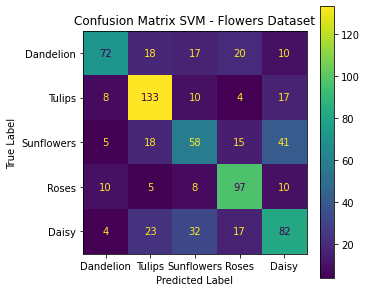


Classes: Dandelion, Tulips, Sunflowers, Roses, Daisy
True Positive Rate:  [0.53 0.77 0.42 0.75 0.52]
False Positive Rate:  [0.05 0.11 0.11 0.09 0.14]
F1 Score:  [0.61 0.72 0.44 0.69 0.52]
Accurcay:  [0.87 0.86 0.8  0.88 0.79]
Total Accurcay:  0.841



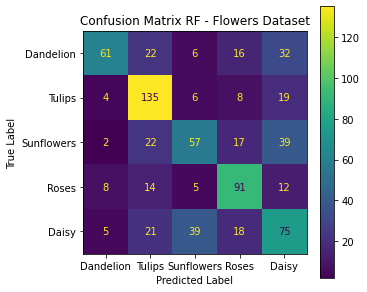


Classes: Dandelion, Tulips, Sunflowers, Roses, Daisy
True Positive Rate:  [0.45 0.78 0.42 0.7  0.47]
False Positive Rate:  [0.03 0.14 0.09 0.1  0.18]
F1 Score:  [0.56 0.7  0.46 0.65 0.45]
Accurcay:  [0.87 0.84 0.81 0.87 0.75]
Total Accurcay:  0.828



In [ ]:
#developing the confusion matrix for svm classifier
cm = confusion_matrix(true_classes,predict_classes)
cm_display = ConfusionMatrixDisplay(confusion_matrix = cm, display_labels = ['Dandelion', 'Tulips', 'Sunflowers', 'Roses', 'Daisy'])

fig, ax = plt.subplots(figsize=(5,5))
cm_display.plot(ax=ax)
plt.title("Confusion Matrix SVM - Flowers Dataset")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

FP = cm.sum(axis=0) - np.diag(cm) #false positive
FN = cm.sum(axis=1) - np.diag(cm) #false negative
TP = np.diag(cm) #true positive
TN = cm.sum() - (FP + FN + TP) #true negative

TPR = TP/(TP+FN) #true positive rate
FPR = FP/(FP+TN) #false positive rate
F1 = TP/(TP + (0.5*(FP+FN))) #f1 score
ACC = (TP+TN)/(TP+FP+FN+TN) #model accuracy

print()
print("Classes: Dandelion, Tulips, Sunflowers, Roses, Daisy")
print("True Positive Rate: ", np.round(TPR, 2))
print("False Positive Rate: ", np.round(FPR, 2))
print("F1 Score: ", np.round(F1, 2))
print("Accurcay: ", np.round(ACC, 2))
print("Total Accurcay: ", round(sum(ACC)/5, 3))
print()

#developing the confusion matrix for random forest classifier
cm2 = confusion_matrix(true_classes,predict_classes2)
cm2_display = ConfusionMatrixDisplay(confusion_matrix = cm2, display_labels = ['Dandelion', 'Tulips', 'Sunflowers', 'Roses', 'Daisy'])

fig, ax = plt.subplots(figsize=(5,5))
cm2_display.plot(ax=ax)
plt.title("Confusion Matrix RF - Flowers Dataset")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

FP = cm2.sum(axis=0) - np.diag(cm2) #false positive
FN = cm2.sum(axis=1) - np.diag(cm2) #false negative
TP = np.diag(cm2) #true positive
TN = cm2.sum() - (FP + FN + TP) #true negative

TPR = TP/(TP+FN) #true positive rate
FPR = FP/(FP+TN) #false positive rate
F1 = TP/(TP + (0.5*(FP+FN))) #f1 score
ACC = (TP+TN)/(TP+FP+FN+TN) #model accuracy

print()
print("Classes: Dandelion, Tulips, Sunflowers, Roses, Daisy")
print("True Positive Rate: ", np.round(TPR, 2))
print("False Positive Rate: ", np.round(FPR, 2))
print("F1 Score: ", np.round(F1, 2))
print("Accurcay: ", np.round(ACC, 2))
print("Total Accurcay: ", round(sum(ACC)/5, 3))
print()

**Qualitative Results (Correctly & Incorrectly Classified Images)**

Correctly Classified Image
True Label:  Dandelion


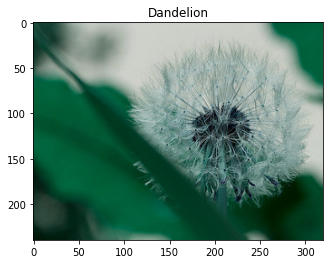

In [ ]:
#showing a correctly classified flower
im=cv2.imread(image_paths_test[1])
plt.imshow(im)
plt.title(predict_classes[1].capitalize())

print("Correctly Classified Image")
print("True Label: ", true_classes[1].capitalize())

Incorrectly Classified Image
True Label:  Daisy


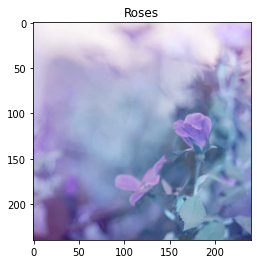

In [ ]:
#showing an incorrectly classified flower
im=cv2.imread(image_paths[27])
plt.imshow(im)
plt.title(predict_classes[27].capitalize())

print("Incorrectly Classified Image")
print("True Label: ", true_classes[27].capitalize())

**Saving Trained Classifiers With JobLib**

In [ ]:
#saving trained svm classifier
filename = "sift_flowers_svm.joblib"
joblib.dump(clf, filename)

['sift_flowers_svm.joblib']

In [ ]:
#saving trained random forest classifier
filename = "sift_flowers_rf.joblib"
joblib.dump(clf2, filename)

['sift_flowers_rf.joblib']